### Binary classification for heart disease

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder          
from sklearn.compose import make_column_transformer            
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

In [2]:
heart = pd.read_csv('heart_disease_data.csv')
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


#### EDA for feature selection

Note that for FastingBS column (fasting blood sugar), 1 represents fastingBS > 120 mg/dl and 0 represents fastingBS <120 mg/dl

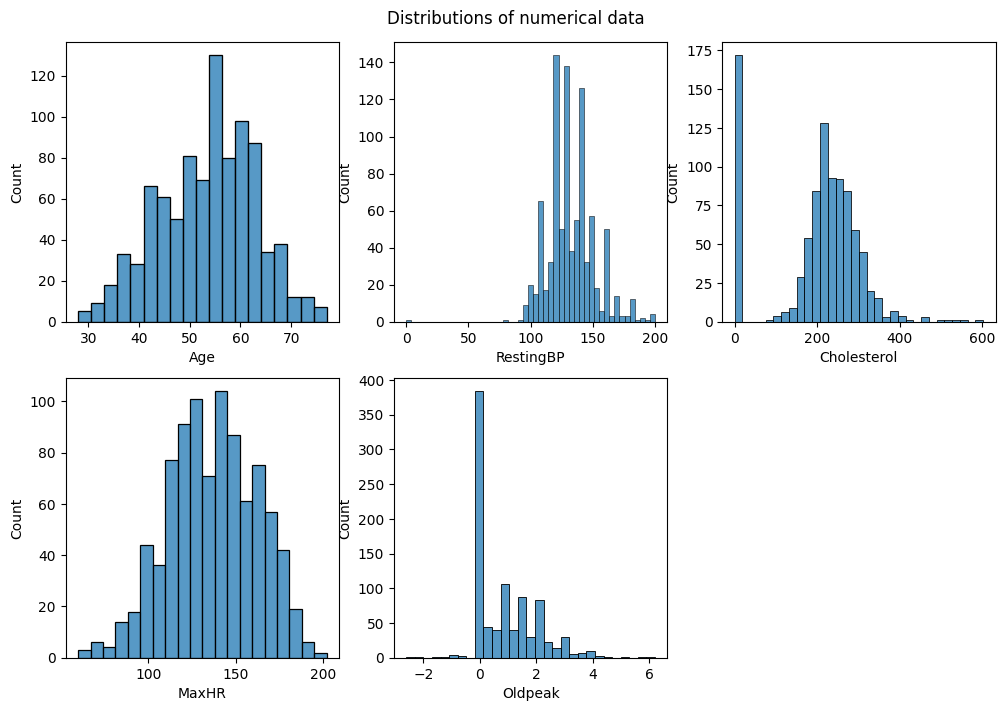

In [4]:
distributions = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

fig = plt.figure(figsize=(12,8))
fig.suptitle('Distributions of numerical data', size=12, y=0.92)
for idx, col in enumerate(distributions):
    ax = plt.subplot(2, 3, idx+1)
    sns.histplot(data=heart, x=col, ax=ax)
plt.show()

The cholesterol column has 172 datapoints with zero values for cholesterol which is abnormal, therefore these columns will be filled with the mean of the column.

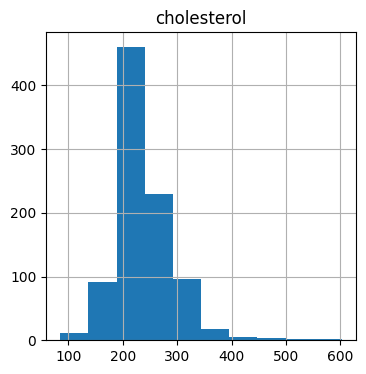

In [5]:
cholesterol_mean = int(round(heart['Cholesterol'].mean(),0))
heart.loc[heart['Cholesterol']==0, 'Cholesterol'] = cholesterol_mean

plt.figure(figsize=(4,4))
heart['Cholesterol'].hist()
plt.title('cholesterol')
plt.show()

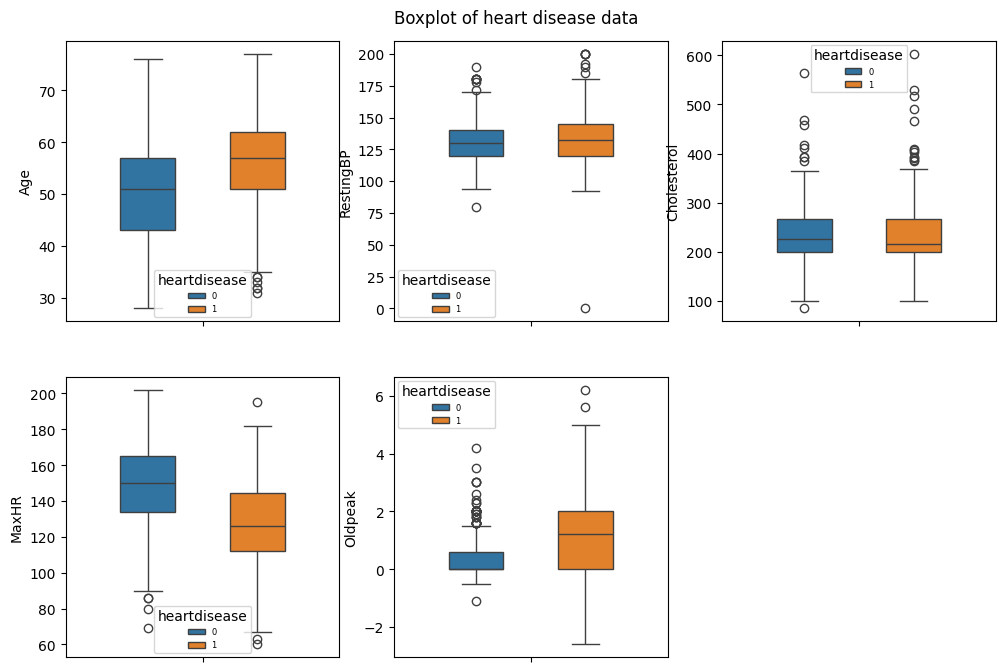

In [6]:
distributions = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

fig = plt.figure(figsize=(12,8))
fig.suptitle('Boxplot of heart disease data', size=12, y=0.92)
for idx, col in enumerate(distributions):
    ax = plt.subplot(2, 3, idx+1)
    sns.boxplot(data=heart, y=col, hue='HeartDisease',gap=0.5, ax=ax)
    plt.legend(title='heartdisease', fontsize=6)
plt.show()

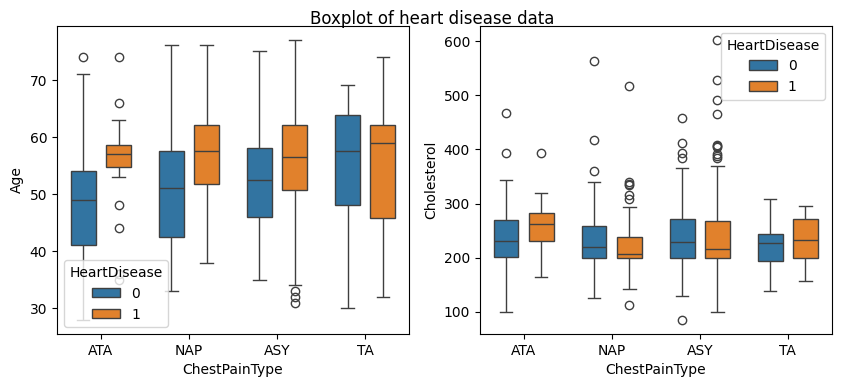

In [7]:
distributions = ['Age', 'Cholesterol', ]

fig = plt.figure(figsize=(10,4))
fig.suptitle('Boxplot of heart disease data', size=12, y=0.92)
for idx, col in enumerate(distributions):
    ax = plt.subplot(1, 2, idx+1)
    sns.boxplot(data=heart, y=col, x='ChestPainType', hue='HeartDisease',gap=0.3,
                native_scale=True, ax=ax)
plt.show()

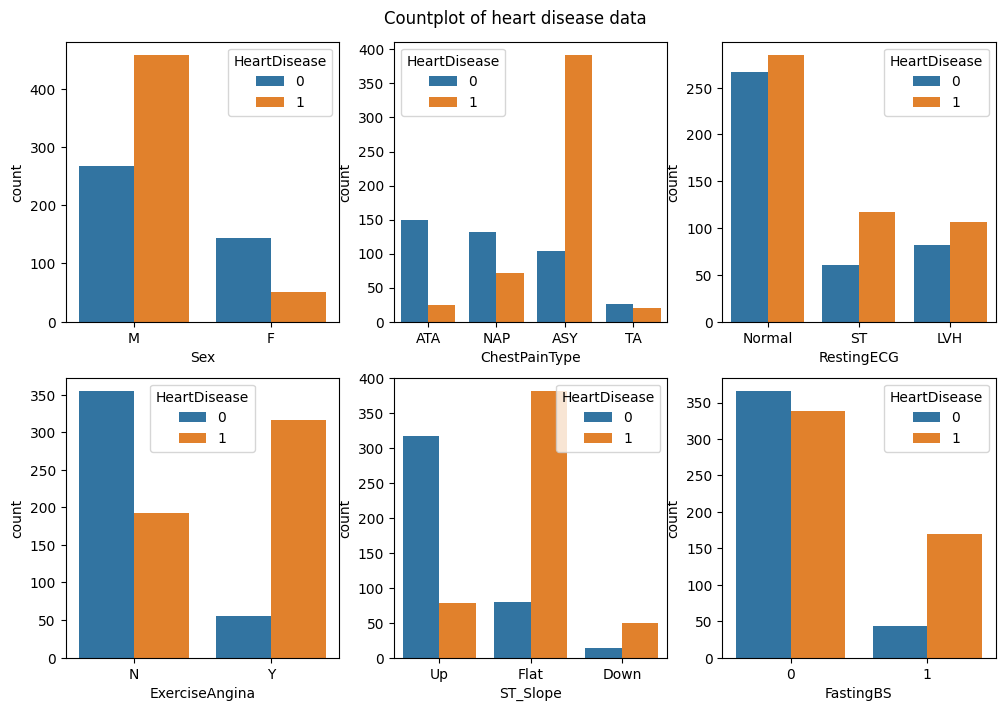

In [8]:
cat = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

fig = plt.figure(figsize=(12,8))
fig.suptitle('Countplot of heart disease data', size=12, y=0.92)
for idx, col in enumerate(cat):
    ax = plt.subplot(2, 3, idx+1)
    sns.countplot(data=heart,  x=col, hue='HeartDisease', ax=ax)
plt.show()

In [9]:
positive_heart = heart.groupby('HeartDisease').get_group(1).agg('mean', numeric_only=True)
negative_heart = heart.groupby('HeartDisease').get_group(0).agg('mean', numeric_only=True)

positive_heart = pd.DataFrame(positive_heart.reset_index()).rename(columns={0:'positive'})
negative_heart = pd.DataFrame(negative_heart.reset_index()).rename(columns={0:'negative'})

aggregate_heart_disease = negative_heart.merge(positive_heart, on='index')
aggregate_heart_disease

,index,negative,positive
0,Age,50.551220,55.899606
1,RestingBP,130.180488,134.185039
2,Cholesterol,236.829268,235.484252
3,FastingBS,0.107317,0.334646
4,MaxHR,148.151220,127.655512
5,Oldpeak,0.408049,1.274213
6,HeartDisease,0.000000,1.000000


In [10]:
heart_corr = heart.corr(numeric_only=True)
heart_corr

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.254399,0.006594,0.198039,-0.382045,0.258612,0.282039
RestingBP,0.254399,1.000000,0.098901,0.070193,-0.112135,0.164803,0.107589
Cholesterol,0.006594,0.098901,1.000000,-0.061545,0.072286,0.059116,-0.011901
FastingBS,0.198039,0.070193,-0.061545,1.000000,-0.131438,0.052698,0.267291
MaxHR,-0.382045,-0.112135,0.072286,-0.131438,1.000000,-0.160691,-0.400421
Oldpeak,0.258612,0.164803,0.059116,0.052698,-0.160691,1.000000,0.403951
HeartDisease,0.282039,0.107589,-0.011901,0.267291,-0.400421,0.403951,1.000000


The distribution of most the numerical variables are close to normal distributions and have similar ranges except for fastingBS column.  The boxplots indicated that patients who are positive for heart disease are slightly older with wider Oldpeak (on ECG) ranges but lower maximum heart rate ranges. The boxplot also indicated that patients with ATA chestpaintype over 55 years almost all have heart disease but not much difference can be seen for other chestpaintypes. Finally, the data showed barplots showed that the sex is moslty men and this may be due to how the data was collected and also most heart disease patients have ASY chestpain type with exercise angina and flat st_slope. 

The discriptive stats shows differences in averages of MaxHr and Oldpeak, and the correlations tables show age, maxHr and oldpeak have the highest correlations. 

For our model, we will choose   
1. age: because it plays a role in heart disease   
2. cholesterol: because it is health risk factor  
3. chestpaintype: because our data shows that people over 55 with ATA mostly are positive and most patients have ASY chestpain type. 


#### preparing the data for modelling
Linear classification shall be used for modelling.  
I will be using two models one with chestpaintype in the model and another without to compare their performances

In [11]:
heart_sub = heart[['Age', 'Cholesterol', 'ChestPainType', 'HeartDisease']]

col_transform = make_column_transformer((OneHotEncoder(),
                                        ['ChestPainType']),
                                        remainder='passthrough',
                                        verbose_feature_names_out=False)

onehot_df = col_transform.fit_transform(heart_sub)

heart_transformed = pd.DataFrame(onehot_df, columns=col_transform.get_feature_names_out())

heart_transformed.head()

,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,Age,Cholesterol,HeartDisease
0,0.0,1.0,0.0,0.0,40.0,289.0,0.0
1,0.0,0.0,1.0,0.0,49.0,180.0,1.0
2,0.0,1.0,0.0,0.0,37.0,283.0,0.0
3,1.0,0.0,0.0,0.0,48.0,214.0,1.0
4,0.0,0.0,1.0,0.0,54.0,195.0,0.0


In [12]:
X1 = heart_transformed.drop(['HeartDisease'], axis=1)
y1 = heart_transformed['HeartDisease']

X2 = heart[['Age', 'Cholesterol']]
y2 = heart['HeartDisease']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,
                                                       random_state=3)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2,
                                                        random_state=3)


In [13]:
print(f'y1 train split: {y1_train.value_counts(normalize=True)*100}\n')
print(f'y1 test split: {y1_test.value_counts(normalize=True)*100}\n')
print(f'y2 train split: {y2_train.value_counts(normalize=True)*100}\n')
print(f'y2 test split: {y2_test.value_counts(normalize=True)*100}\n')

y1 train split: HeartDisease
1.0    55.858311
0.0    44.141689
Name: proportion, dtype: float64

y1 test split: HeartDisease
1.0    53.26087
0.0    46.73913
Name: proportion, dtype: float64

y2 train split: HeartDisease
1    55.858311
0    44.141689
Name: proportion, dtype: float64

y2 test split: HeartDisease
1    53.26087
0    46.73913
Name: proportion, dtype: float64



In [14]:
model1 = LogisticRegression()

model1.fit(X1_train, y1_train)
model1_train_accuracy = model1.score(X1_train, y1_train)
model1_train_pred = model1.predict(X1_train)

model1_train_TP = sum((y1_train == 1.0) & (model1_train_pred==1.0))
model1_train_FN = sum((y1_train == 1.0) & (model1_train_pred==0.0))
model1_train_sensitivity = model1_train_TP / (model1_train_TP + model1_train_FN)

model1_train_TN = sum((y1_train == 0.0) & (model1_train_pred==0.0))
model1_train_FP = sum((y1_train == 0.0) & (model1_train_pred==1.0))

model1_train_specificity = model1_train_TN / (model1_train_TN + model1_train_FP)

print(f'model 1 train accuracy: {model1_train_accuracy}')
print(f'model 1 train sensitivity: {model1_train_sensitivity}')
print(f'model 1 train specificity: {model1_train_specificity}')

model 1 train accuracy: 0.7520435967302452
model 1 train sensitivity: 0.8073170731707318
model 1 train specificity: 0.6820987654320988


C:\Users\austi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model1 used age, cholesterol and chestpaintype for predictions.    
The model1 performance accuracy is 75% and is able to predict class 1 better with 80% sensitivity. The class zero predictions are a lot lower and has a specificity of only 68%. 

In [15]:
## trying out model 2

model2 = LogisticRegression()

model2.fit(X2_train, y2_train)
model2_train_accuracy = model2.score(X2_train, y2_train)
model2_train_pred = model2.predict(X2_train)

model2_train_TP = sum((y2_train == 1) & (model2_train_pred==1))
model2_train_FN = sum((y2_train == 1) & (model2_train_pred==0))
model2_train_sensitivity = model2_train_TP / (model2_train_TP + model2_train_FN)

model2_train_TN = sum((y2_train == 0) & (model2_train_pred==0))
model2_train_FP = sum((y2_train == 0) & (model2_train_pred==1))

model2_train_specificity = model2_train_TN / (model2_train_TN + model2_train_FP)

print(f'model 2 train accuracy: {model2_train_accuracy}')
print(f'model 2 train sensitivity: {model2_train_sensitivity}')
print(f'model 2 train specificity: {model2_train_specificity}')

model 2 train accuracy: 0.6280653950953679
model 2 train sensitivity: 0.7780487804878049
model 2 train specificity: 0.4382716049382716


Model2 used only age and cholesterol for predictions.   
The model2 performance is lot lower than model1. Model2 has 63% accuracy, 78% sensitivity and 44% specificity. 

In [16]:
## intercepts for model 1 
model1_intercept_log = model1.intercept_
model1_intercept_odds = np.exp(model1_intercept_log)

model1_coeff_log = model1.coef_
model1_coeff_odds = np.exp(model1_coeff_log)

print(f'model 1 odds {model1_intercept_odds[0]:.5f}\n')

model1_train_columns = X1_train.columns
for col, odd in zip(model1_train_columns, model1_coeff_odds[0]):
    print(f'{col} odds ratio : {odd:.5f}')

model 1 odds 0.09534

ChestPainType_ASY odds ratio : 2.92839
ChestPainType_ATA odds ratio : 0.19442
ChestPainType_NAP odds ratio : 0.42608
ChestPainType_TA odds ratio : 0.63849
Age odds ratio : 1.05704
Cholesterol odds ratio : 0.99824


In [17]:
## intercepts for model 2 
model2_intercept_log = model2.intercept_
model2_intercept_odds = np.exp(model2_intercept_log)

model2_coeff_log = model2.coef_
model2_coeff_odds = np.exp(model2_coeff_log)

print(f'model 2 odds {model2_intercept_odds[0]:.5f}\n')

model2_train_columns = X2_train.columns
for col, odd in zip(model2_train_columns, model2_coeff_odds[0]):
    print(f'{col} odds ratio : {odd:.5f}')

model 2 odds 0.05443

Age odds ratio : 1.06458
Cholesterol odds ratio : 0.99920


In model 1, the odds ratio indicate that when ChestPainType-ASY predictor is zero and controlling for other predictors, the patient likely does not have heart disease. The odds ratio for chestpain ASY is approx 3 which suggests it is most likely associated with heart disease. Age and Cholesterol also have odds ratios of approx. 1 meaning they are likely to be associated with heart disease. The other parameters are below 1 suggesting they may not likely be associated with heart disease. 

In Model 2, the odds ratio indicate that when age predictor is zero adn controlling for cholesterol, the patient likely does not have heart disease. Tehn the age and cholesterol approx 1 odds ratio suggesting they may be associated with heart disease but this isn't very strong indicator. 

#### Evaluating the models on test data

In [18]:
model1_test_accuracy = model1.score(X1_test, y1_test)
model1_test_pred = model1.predict(X1_test)

model1_test_TP = sum((y1_test == 1.0) & (model1_test_pred==1.0))
model1_test_FN = sum((y1_test == 1.0) & (model1_test_pred==0.0))
model1_test_sensitivity = model1_test_TP / (model1_test_TP + model1_test_FN)

model1_test_TN = sum((y1_test == 0.0) & (model1_test_pred==0.0))
model1_test_FP = sum((y1_test == 0.0) & (model1_test_pred==1.0))

model1_test_specificity = model1_test_TN / (model1_test_TN + model1_test_FP)

print(f'model 1 test accuracy: {model1_test_accuracy}')
print(f'model 1 test sensitivity: {model1_test_sensitivity}')
print(f'model 1 test specificity: {model1_test_specificity}')

model 1 test accuracy: 0.7771739130434783
model 1 test sensitivity: 0.8163265306122449
model 1 test specificity: 0.7325581395348837


In [19]:
model2_test_accuracy = model2.score(X2_test, y2_test)
model2_test_pred = model2.predict(X2_test)

model2_test_TP = sum((y2_test == 1.0) & (model2_test_pred==1.0))
model2_test_FN = sum((y2_test == 1.0) & (model2_test_pred==0.0))
model2_test_sensitivity = model2_test_TP / (model2_test_TP + model2_test_FN)

model2_test_TN = sum((y2_test == 0.0) & (model2_test_pred==0.0))
model2_test_FP = sum((y2_test == 0.0) & (model2_test_pred==1.0))

model2_test_specificity = model2_test_TN / (model2_test_TN + model2_test_FP)

print(f'model 2 test accuracy: {model2_test_accuracy}')
print(f'model 2 test sensitivity: {model2_test_sensitivity}')
print(f'model 2 test specificity: {model2_test_specificity}')

model 2 test accuracy: 0.6195652173913043
model 2 test sensitivity: 0.7857142857142857
model 2 test specificity: 0.43023255813953487


Testing the performance of model 1 on the test data, overall shows better performance increase in accurcacy to ca 78%, sensitivity to ca 82% and specificity to ca 73%. This is better than the training performance which indicates the model is performing well generally though there is still room for optimisation. 

For model 2, testing the model on the test data did not show any improvement from the metrics of the training data. accuracy is ca 62%, sensitivity ca 78% and specificity ca 43%. Overall it didn't perform better or worse on unseen data. 


##### Conclusion
Model 1 is seen to be able to predict up to 78% heart disease accurately and can predict positive heart disease up to 82% of the time and negative heart disease up to 77% of the time.  
The model has more rooms for improvement and even though at this performance level cannot be used for clinical diagnosis, is suitable for making  inferences into a likelyhood of heart disease.